In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [70]:
#colors!

c_d = '#1b9e77'
c_i = '#d95f02'
c_c = '#7570b3'

## Import data

In [71]:
# research article data

domestic_research = pd.read_csv('data/domestic_brazil_research.csv')
international_research = pd.read_csv('data/international_brazil_research.csv')
collaborative_research = pd.read_csv('data/collaboration_brazil_research.csv')

domestic_research = domestic_research[domestic_research['Publication Year'] < 2022]
international_research = international_research[international_research['Publication Year'] < 2022]
collaborative_research = collaborative_research[collaborative_research['Publication Year'] < 2022]

domestic_research = domestic_research.reset_index(drop=True)
international_research = international_research.reset_index(drop=True)
collaborative_research = collaborative_research.reset_index(drop=True)


# deforestation data

deforestation_df = pd.read_csv('data/deforestation_data.csv')

## Pre-processing data

Aligning year ranges between the data

In [72]:
min_year = max([min(domestic_research['Publication Year']), min(international_research['Publication Year']), min(collaborative_research['Publication Year']), min(deforestation_df['year'])])

deforestation_df = deforestation_df[deforestation_df['year']  >= min_year]
domestic_research = domestic_research[domestic_research['Publication Year'] >= min_year]
international_research = international_research[international_research['Publication Year'] >= min_year]
collaborative_research = collaborative_research[collaborative_research['Publication Year'] >= min_year]

deforestation_df = deforestation_df.reset_index(drop=True)
domestic_research = domestic_research.reset_index(drop=True)
international_research = international_research.reset_index(drop=True)
collaborative_research = collaborative_research.reset_index(drop=True)

Dataframes to hold final predictor/response data

In [73]:
domestic_df = pd.DataFrame({'Year': np.arange(min_year, 2022), 'Deforestation_Rate': deforestation_df['deforestation_rate']})
international_df = pd.DataFrame({'Year': np.arange(min_year, 2022), 'Deforestation_Rate': deforestation_df['deforestation_rate']})
collaborative_df = pd.DataFrame({'Year': np.arange(min_year, 2022), 'Deforestation_Rate': deforestation_df['deforestation_rate']})

Processing article data to get AR index citation metric

In [74]:
def calculate_AR_index(citations, year):
    
    citations = np.array(citations)
    n = citations.shape[0]
    array = np.arange(1, n+1)

    # reverse sorting
    citations = np.sort(citations)[::-1]           

    # computing h-index
    h_idx = np.max(np.minimum(citations, array))
    
    # computing AR index
    paper_age = 2022 - year
    AR = np.sqrt(sum(citations[0:h_idx-1]) / (paper_age))
    
    return AR 

In [75]:
def process_article_data(article_df, year_list):
    
    AR_index_list = []
    
    for year in year_list:
        article_df_year = article_df[article_df['Publication Year'] == year]
        AR_index_list.append(calculate_AR_index(article_df_year['Times Cited, All Databases'], year))
        
    return AR_index_list

In [76]:
domestic_df['AR_Index'] = process_article_data(domestic_research, domestic_df['Year'])

international_df['AR_Index'] = process_article_data(international_research, international_df['Year'])

collaborative_df['AR_Index'] = process_article_data(collaborative_research, collaborative_df['Year'])

### Making time-shifted variables

In [77]:
def get_shift(df, steps_back, min_year):
    
    df_shifted = pd.DataFrame({'Year': np.arange(min_year+steps_back, 2022)})
    
    deforestation_list = np.asarray(df['Deforestation_Rate'])
    deforestation_list = deforestation_list[steps_back:len(deforestation_list)]
    df_shifted['Deforestation_Rate'] = deforestation_list
    
    AR_list = np.asarray(df['AR_Index'])
    AR_list = AR_list[0:len(AR_list)-steps_back]
    df_shifted[f'AR_Index_{steps_back}_Year_Prev'] = AR_list
    
    return df_shifted

In [78]:
domestic_df_list = [domestic_df]
international_df_list = [international_df]
collaborative_df_list = [collaborative_df]

# time shifts of 1-5 years
for i in range(1, 6):

    domestic_df_list.append(get_shift(domestic_df, i, min_year)) 
    international_df_list.append(get_shift(international_df, i, min_year)) 
    collaborative_df_list.append(get_shift(collaborative_df, i, min_year)) 

## Plots of raw data

### Deforestation rate timeseries

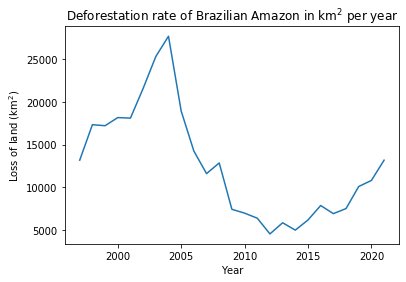

In [79]:
plt.plot(domestic_df['Year'], domestic_df['Deforestation_Rate'])
plt.title(r'Deforestation rate of Brazilian Amazon in km$^2$ per year')
plt.xlabel('Year')
plt.ylabel(r'Loss of land (km$^2$)')
plt.show()

### AR index timeseries

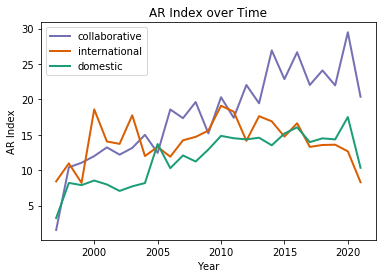

In [80]:
plt.plot(collaborative_df['Year'], collaborative_df['AR_Index'], color=c_c, linewidth=2, label='collaborative')
plt.plot(international_df['Year'], international_df['AR_Index'], color=c_i, linewidth=2, label='international')
plt.plot(domestic_df['Year'], domestic_df['AR_Index'], color=c_d, linewidth=2, label='domestic')
plt.title('AR Index over Time')
plt.xlabel('Year')
plt.ylabel('AR Index')
plt.legend()
         
plt.show()

### Scatter plots of AR Index vs. Deforestation rate

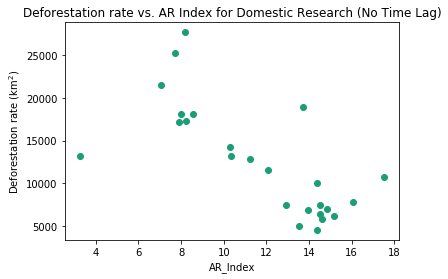

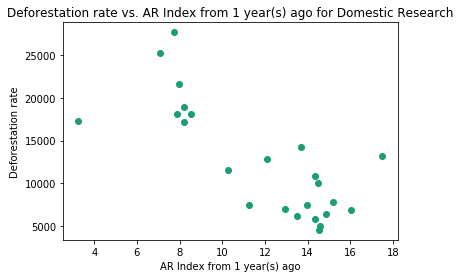

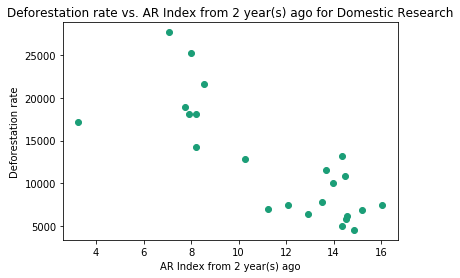

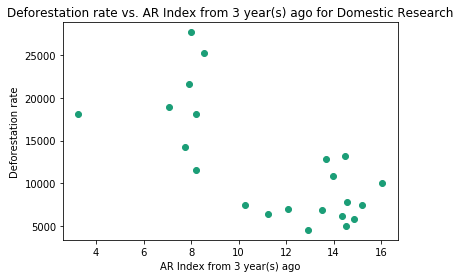

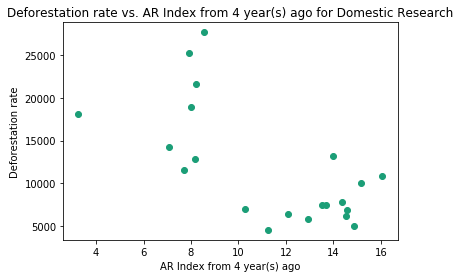

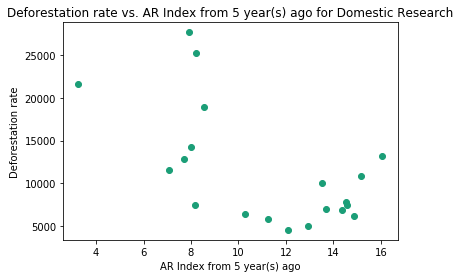

In [81]:
for i in range(0, 6):
    if i==0:
        plt.scatter(domestic_df_list[i]['AR_Index'], domestic_df_list[i]['Deforestation_Rate'], color=c_d)
        plt.xlabel('AR_Index')
        plt.ylabel(r'Deforestation rate (km$^2$)')
        plt.title('Deforestation rate vs. AR Index for Domestic Research (No Time Lag)')
        plt.show()
    else:
        plt.scatter(domestic_df_list[i][f'AR_Index_{i}_Year_Prev'], domestic_df_list[i]['Deforestation_Rate'], color=c_d)
        plt.title(f'Deforestation rate vs. AR Index from {i} year(s) ago for Domestic Research')
        plt.xlabel(f'AR Index from {i} year(s) ago')
        plt.ylabel('Deforestation rate')
        plt.show()

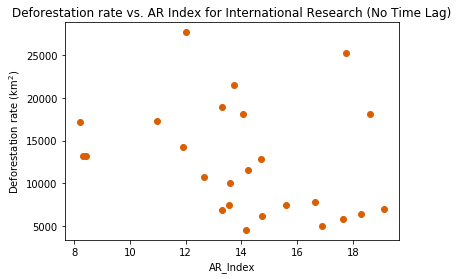

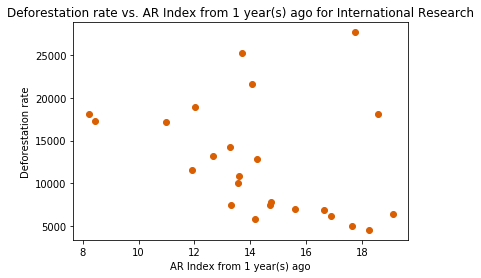

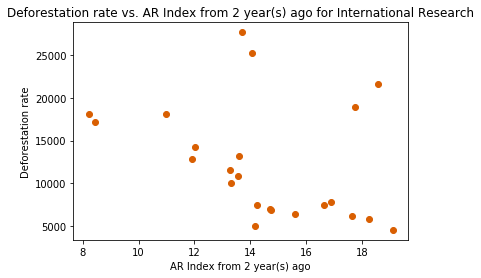

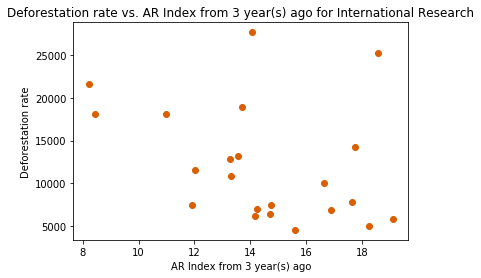

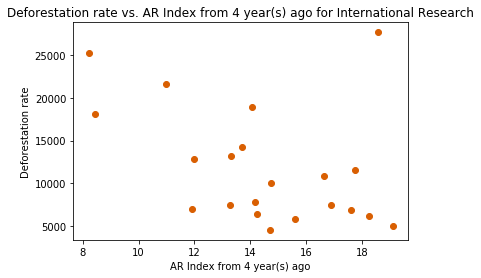

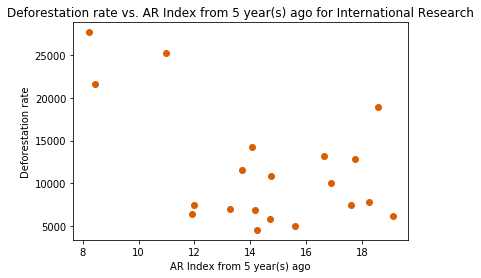

In [82]:
for i in range(0, 6):
    if i==0:
        plt.scatter(international_df_list[i]['AR_Index'], international_df_list[i]['Deforestation_Rate'], color=c_i)
        plt.xlabel('AR_Index')
        plt.ylabel(r'Deforestation rate (km$^2$)')
        plt.title('Deforestation rate vs. AR Index for International Research (No Time Lag)')
        plt.show()
    else:
        plt.scatter(international_df_list[i][f'AR_Index_{i}_Year_Prev'], international_df_list[i]['Deforestation_Rate'], color=c_i)
        plt.title(f'Deforestation rate vs. AR Index from {i} year(s) ago for International Research')
        plt.xlabel(f'AR Index from {i} year(s) ago')
        plt.ylabel('Deforestation rate')
        plt.show()

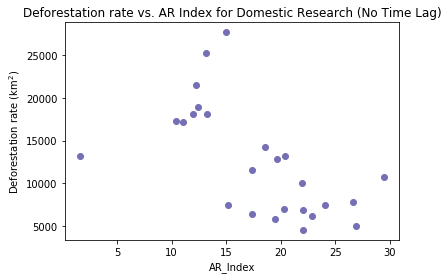

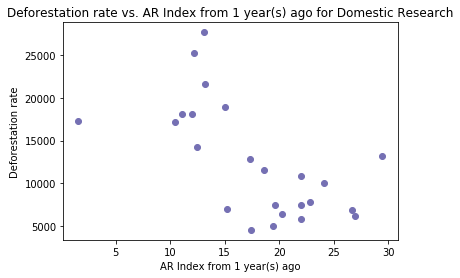

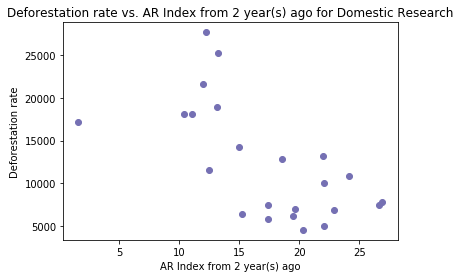

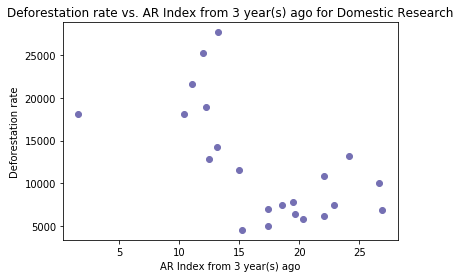

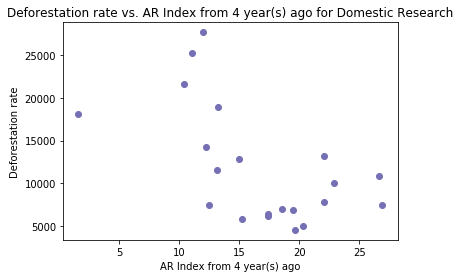

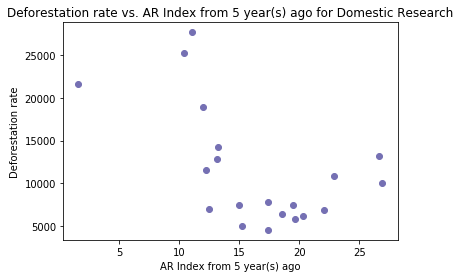

In [83]:
for i in range(0, 6):
    if i==0:
        plt.scatter(collaborative_df_list[i]['AR_Index'], collaborative_df_list[i]['Deforestation_Rate'], color=c_c)
        plt.xlabel('AR_Index')
        plt.ylabel(r'Deforestation rate (km$^2$)')
        plt.title('Deforestation rate vs. AR Index for Domestic Research (No Time Lag)')
        plt.show()
    else:
        plt.scatter(collaborative_df_list[i][f'AR_Index_{i}_Year_Prev'], collaborative_df_list[i]['Deforestation_Rate'], color=c_c)
        plt.title(f'Deforestation rate vs. AR Index from {i} year(s) ago for Domestic Research')
        plt.xlabel(f'AR Index from {i} year(s) ago')
        plt.ylabel('Deforestation rate')
        plt.show()

# Model fitting

In [84]:
import statsmodels.api as sm
from scipy.interpolate import interp1d
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

import patsy as pt

In [85]:
domestic_df_list[1].columns

Index(['Year', 'Deforestation_Rate', 'AR_Index_1_Year_Prev'], dtype='object')

## Linear regression and significance testing

### Domestic

                            OLS Regression Results                            
Dep. Variable:     Deforestation_Rate   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     24.08
Date:                Sun, 01 May 2022   Prob (F-statistic):           5.87e-05
Time:                        11:32:38   Log-Likelihood:                -245.56
No. Observations:                  25   AIC:                             495.1
Df Residuals:                      23   BIC:                             497.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.798e+04   3270.633      8.554      0.0

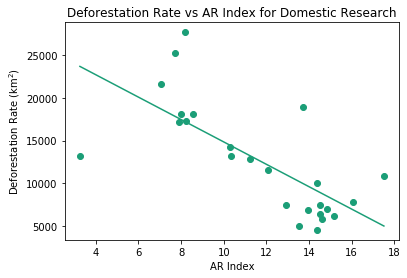

                            OLS Regression Results                            
Dep. Variable:     Deforestation_Rate   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     31.40
Date:                Sun, 01 May 2022   Prob (F-statistic):           1.24e-05
Time:                        11:32:38   Log-Likelihood:                -234.18
No. Observations:                  24   AIC:                             472.4
Df Residuals:                      22   BIC:                             474.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.919e+04 

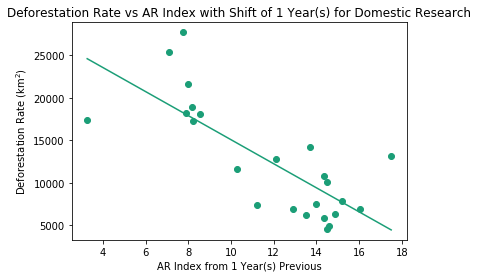

                            OLS Regression Results                            
Dep. Variable:     Deforestation_Rate   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     36.20
Date:                Sun, 01 May 2022   Prob (F-statistic):           5.69e-06
Time:                        11:32:38   Log-Likelihood:                -223.32
No. Observations:                  23   AIC:                             450.6
Df Residuals:                      21   BIC:                             452.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 3.009e+04 

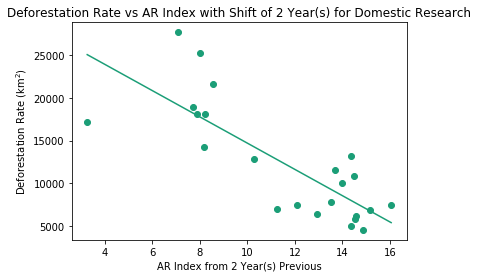

                            OLS Regression Results                            
Dep. Variable:     Deforestation_Rate   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     18.90
Date:                Sun, 01 May 2022   Prob (F-statistic):           0.000313
Time:                        11:32:38   Log-Likelihood:                -217.53
No. Observations:                  22   AIC:                             439.1
Df Residuals:                      20   BIC:                             441.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.755e+04 

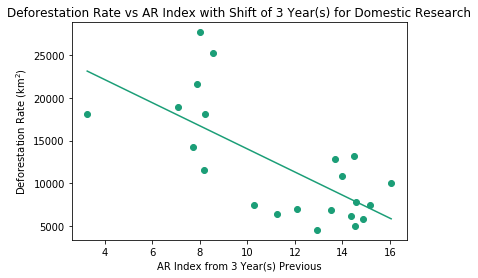

                            OLS Regression Results                            
Dep. Variable:     Deforestation_Rate   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     14.21
Date:                Sun, 01 May 2022   Prob (F-statistic):            0.00130
Time:                        11:32:38   Log-Likelihood:                -208.83
No. Observations:                  21   AIC:                             421.7
Df Residuals:                      19   BIC:                             423.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.613e+04 

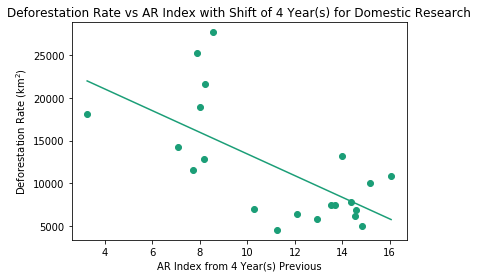

                            OLS Regression Results                            
Dep. Variable:     Deforestation_Rate   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     10.22
Date:                Sun, 01 May 2022   Prob (F-statistic):            0.00500
Time:                        11:32:39   Log-Likelihood:                -200.01
No. Observations:                  20   AIC:                             404.0
Df Residuals:                      18   BIC:                             406.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.443e+04 

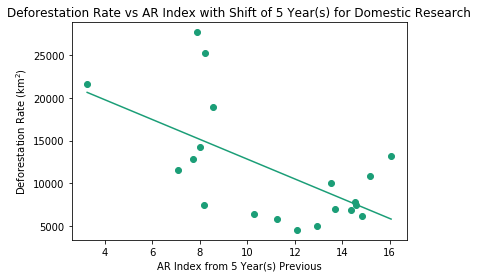

In [89]:
X = domestic_df_list[0]['AR_Index']
y = domestic_df_list[0]['Deforestation_Rate']
sk_model = sm.OLS(y, sm.add_constant(X))
results = sk_model.fit()
print(results.summary())
f = interp1d(domestic_df_list[0]['AR_Index'], results.predict(sm.add_constant(domestic_df_list[0]['AR_Index'])), bounds_error=False)
y_preds = f(domestic_df_list[0]['AR_Index'])
X_vis, y_preds = zip(*sorted(zip(domestic_df_list[0]['AR_Index'], y_preds)))
plt.scatter(domestic_df_list[0]['AR_Index'], domestic_df_list[0]['Deforestation_Rate'], color=c_d)
plt.plot(X_vis, y_preds, label='Predicted Rate', color=c_d)
plt.title(f'Deforestation Rate vs AR Index for Domestic Research')
plt.xlabel('AR Index')
plt.ylabel(r'Deforestation Rate (km$^2$)')
plt.show()

for i in range(1,6):
    X = domestic_df_list[i][f'AR_Index_{i}_Year_Prev']
    y = domestic_df_list[i]['Deforestation_Rate']
    sk_model = sm.OLS(y, sm.add_constant(X))
    results = sk_model.fit()
    print(results.summary())
    
    f = interp1d(domestic_df_list[i][f'AR_Index_{i}_Year_Prev'], results.predict(sm.add_constant(domestic_df_list[i][f'AR_Index_{i}_Year_Prev'])), bounds_error=False)
    y_preds = f(domestic_df_list[i][f'AR_Index_{i}_Year_Prev'])
    X_vis, y_preds = zip(*sorted(zip(domestic_df_list[i][f'AR_Index_{i}_Year_Prev'], y_preds)))
    plt.scatter(domestic_df_list[i][f'AR_Index_{i}_Year_Prev'], domestic_df_list[i]['Deforestation_Rate'], color=c_d)
    plt.plot(X_vis, y_preds, label='Predicted Rate', color=c_d)
    plt.title(f'Deforestation Rate vs AR Index with Shift of {i} Year(s) for Domestic Research')
    plt.xlabel(f'AR Index from {i} Year(s) Previous')
    plt.ylabel(r'Deforestation Rate (km$^2$)')
    plt.show()

### International

                            OLS Regression Results                            
Dep. Variable:     Deforestation_Rate   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1.908
Date:                Sun, 01 May 2022   Prob (F-statistic):              0.180
Time:                        11:31:26   Log-Likelihood:                -253.52
No. Observations:                  25   AIC:                             511.0
Df Residuals:                      23   BIC:                             513.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.082e+04   6091.993      3.417      0.0

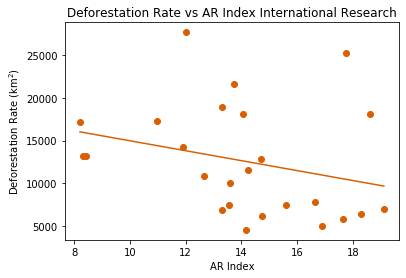

                            OLS Regression Results                            
Dep. Variable:     Deforestation_Rate   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     2.625
Date:                Sun, 01 May 2022   Prob (F-statistic):              0.119
Time:                        11:31:26   Log-Likelihood:                -243.47
No. Observations:                  24   AIC:                             490.9
Df Residuals:                      22   BIC:                             493.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.328e+04 

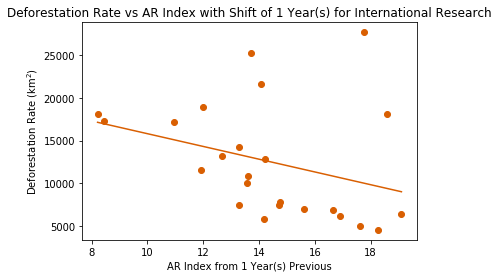

                            OLS Regression Results                            
Dep. Variable:     Deforestation_Rate   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     2.924
Date:                Sun, 01 May 2022   Prob (F-statistic):              0.102
Time:                        11:31:26   Log-Likelihood:                -233.34
No. Observations:                  23   AIC:                             470.7
Df Residuals:                      21   BIC:                             473.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.384e+04 

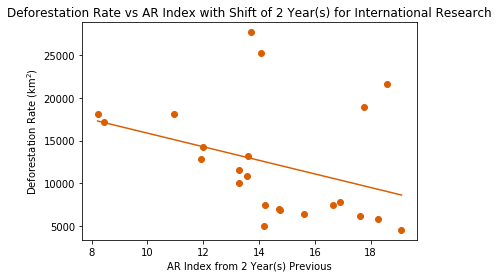

                            OLS Regression Results                            
Dep. Variable:     Deforestation_Rate   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     2.709
Date:                Sun, 01 May 2022   Prob (F-statistic):              0.115
Time:                        11:31:26   Log-Likelihood:                -223.45
No. Observations:                  22   AIC:                             450.9
Df Residuals:                      20   BIC:                             453.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.339e+04 

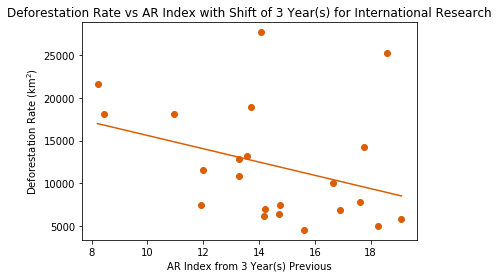

                            OLS Regression Results                            
Dep. Variable:     Deforestation_Rate   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     3.759
Date:                Sun, 01 May 2022   Prob (F-statistic):             0.0675
Time:                        11:31:26   Log-Likelihood:                -212.80
No. Observations:                  21   AIC:                             429.6
Df Residuals:                      19   BIC:                             431.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  2.49e+04 

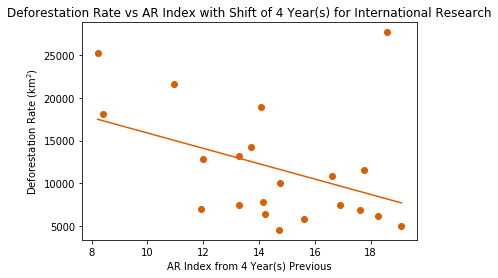

                            OLS Regression Results                            
Dep. Variable:     Deforestation_Rate   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     6.019
Date:                Sun, 01 May 2022   Prob (F-statistic):             0.0246
Time:                        11:31:27   Log-Likelihood:                -201.62
No. Observations:                  20   AIC:                             407.2
Df Residuals:                      18   BIC:                             409.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.738e+04 

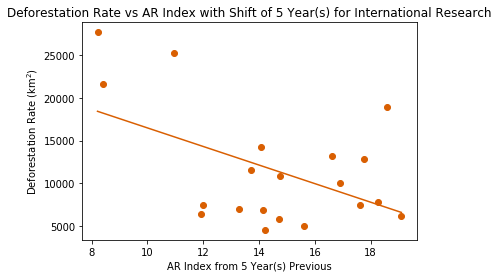

In [86]:
X = international_df_list[0]['AR_Index']
y = international_df_list[0]['Deforestation_Rate']
sk_model = sm.OLS(y, sm.add_constant(X))
results = sk_model.fit()
print(results.summary())
f = interp1d(international_df_list[0]['AR_Index'], results.predict(sm.add_constant(international_df_list[0]['AR_Index'])), bounds_error=False)
y_preds = f(international_df_list[0]['AR_Index'])
X_vis, y_preds = zip(*sorted(zip(international_df_list[0]['AR_Index'], y_preds)))
plt.scatter(international_df_list[0]['AR_Index'], international_df_list[0]['Deforestation_Rate'], color=c_i)
plt.plot(X_vis, y_preds, label='Predicted Rate', color=c_i)
plt.title(f'Deforestation Rate vs AR Index International Research')
plt.xlabel('AR Index')
plt.ylabel(r'Deforestation Rate (km$^2$)')
plt.show()

for i in range(1,6):
    X = international_df_list[i][f'AR_Index_{i}_Year_Prev']
    y = international_df_list[i]['Deforestation_Rate']
    sk_model = sm.OLS(y, sm.add_constant(X))
    results = sk_model.fit()
    print(results.summary())
    
    f = interp1d(international_df_list[i][f'AR_Index_{i}_Year_Prev'], results.predict(sm.add_constant(international_df_list[i][f'AR_Index_{i}_Year_Prev'])), bounds_error=False)
    y_preds = f(international_df_list[i][f'AR_Index_{i}_Year_Prev'])
    X_vis, y_preds = zip(*sorted(zip(international_df_list[i][f'AR_Index_{i}_Year_Prev'], y_preds)))
    plt.scatter(international_df_list[i][f'AR_Index_{i}_Year_Prev'], international_df_list[i]['Deforestation_Rate'], color=c_i)
    plt.plot(X_vis, y_preds, label='Predicted Rate', color=c_i)
    plt.title(f'Deforestation Rate vs AR Index with Shift of {i} Year(s) for International Research')
    plt.xlabel(f'AR Index from {i} Year(s) Previous')
    plt.ylabel(r'Deforestation Rate (km$^2$)')
    plt.show()

### Collaborative

                            OLS Regression Results                            
Dep. Variable:     Deforestation_Rate   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     12.93
Date:                Sun, 01 May 2022   Prob (F-statistic):            0.00152
Time:                        11:31:30   Log-Likelihood:                -248.94
No. Observations:                  25   AIC:                             501.9
Df Residuals:                      23   BIC:                             504.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.366e+04   3257.384      7.263      0.0

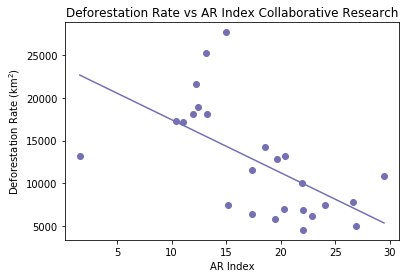

                            OLS Regression Results                            
Dep. Variable:     Deforestation_Rate   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     13.93
Date:                Sun, 01 May 2022   Prob (F-statistic):            0.00116
Time:                        11:31:31   Log-Likelihood:                -238.94
No. Observations:                  24   AIC:                             481.9
Df Residuals:                      22   BIC:                             484.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.402e+04 

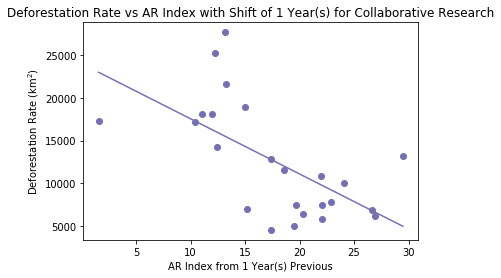

                            OLS Regression Results                            
Dep. Variable:     Deforestation_Rate   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     14.43
Date:                Sun, 01 May 2022   Prob (F-statistic):            0.00105
Time:                        11:31:31   Log-Likelihood:                -228.83
No. Observations:                  23   AIC:                             461.7
Df Residuals:                      21   BIC:                             463.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.461e+04 

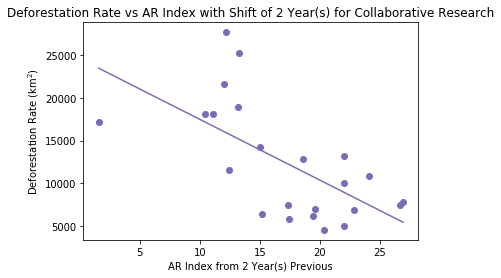

                            OLS Regression Results                            
Dep. Variable:     Deforestation_Rate   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     11.89
Date:                Sun, 01 May 2022   Prob (F-statistic):            0.00255
Time:                        11:31:31   Log-Likelihood:                -219.71
No. Observations:                  22   AIC:                             443.4
Df Residuals:                      20   BIC:                             445.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.374e+04 

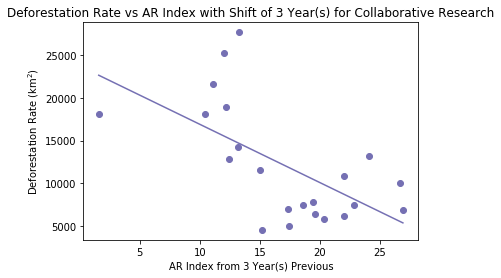

                            OLS Regression Results                            
Dep. Variable:     Deforestation_Rate   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     9.364
Date:                Sun, 01 May 2022   Prob (F-statistic):            0.00644
Time:                        11:31:31   Log-Likelihood:                -210.49
No. Observations:                  21   AIC:                             425.0
Df Residuals:                      19   BIC:                             427.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.272e+04 

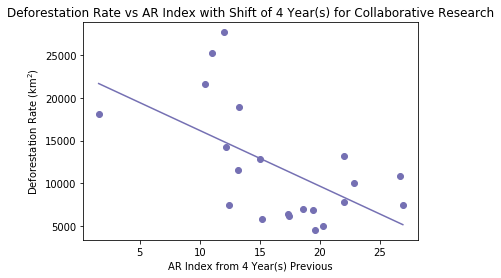

                            OLS Regression Results                            
Dep. Variable:     Deforestation_Rate   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     7.954
Date:                Sun, 01 May 2022   Prob (F-statistic):             0.0113
Time:                        11:31:31   Log-Likelihood:                -200.85
No. Observations:                  20   AIC:                             405.7
Df Residuals:                      18   BIC:                             407.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.183e+04 

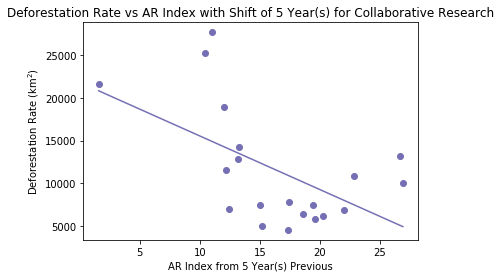

In [87]:
X = collaborative_df_list[0]['AR_Index']
y = collaborative_df_list[0]['Deforestation_Rate']
sk_model = sm.OLS(y, sm.add_constant(X))
results = sk_model.fit()
print(results.summary())
f = interp1d(collaborative_df_list[0]['AR_Index'], results.predict(sm.add_constant(collaborative_df_list[0]['AR_Index'])), bounds_error=False)
y_preds = f(collaborative_df_list[0]['AR_Index'])
X_vis, y_preds = zip(*sorted(zip(collaborative_df_list[0]['AR_Index'], y_preds)))
plt.scatter(collaborative_df_list[0]['AR_Index'], collaborative_df_list[0]['Deforestation_Rate'], color=c_c)
plt.plot(X_vis, y_preds, label='Predicted Rate', color=c_c)
plt.title(f'Deforestation Rate vs AR Index Collaborative Research')
plt.xlabel('AR Index')
plt.ylabel(r'Deforestation Rate (km$^2$)')
plt.show()

for i in range(1,6):
    X = collaborative_df_list[i][f'AR_Index_{i}_Year_Prev']
    y = collaborative_df_list[i]['Deforestation_Rate']
    sk_model = sm.OLS(y, sm.add_constant(X))
    results = sk_model.fit()
    print(results.summary())
    
    f = interp1d(collaborative_df_list[i][f'AR_Index_{i}_Year_Prev'], results.predict(sm.add_constant(collaborative_df_list[i][f'AR_Index_{i}_Year_Prev'])), bounds_error=False)
    y_preds = f(collaborative_df_list[i][f'AR_Index_{i}_Year_Prev'])
    X_vis, y_preds = zip(*sorted(zip(collaborative_df_list[i][f'AR_Index_{i}_Year_Prev'], y_preds)))
    plt.scatter(collaborative_df_list[i][f'AR_Index_{i}_Year_Prev'], collaborative_df_list[i]['Deforestation_Rate'], color=c_c)
    plt.plot(X_vis, y_preds, label='Predicted Rate', color=c_c)
    plt.title(f'Deforestation Rate vs AR Index with Shift of {i} Year(s) for Collaborative Research')
    plt.xlabel(f'AR Index from {i} Year(s) Previous')
    plt.ylabel(r'Deforestation Rate (km$^2$)')
    plt.show()

## Polynomial regression and bootstrapping

In [96]:
def calc_MSE_polynomial_fit(poly_order, X_train, X_val, y_train, y_val):
    if poly_order == 1:
        X_train_poly = X_train
        X_val_poly = X_val
    else:
        # Transform X to appropriate polynomial
        poly = PolynomialFeatures(poly_order)
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.fit_transform(X_val)
    
    # Fit the polynomial regression
    regr_poly = linear_model.LinearRegression()
    regr_poly.fit(X_train_poly, y_train)
    
    # Make predictions using the linear regression
    y_pred_poly_val = regr_poly.predict(X_val_poly)
    y_pred_poly_train = regr_poly.predict(X_train_poly)
    
    # Calculate the MSE for both the val and training sets
    MSE_val = mean_squared_error(y_val, y_pred_poly_val)
    MSE_train = mean_squared_error(y_train, y_pred_poly_train)
    
    return MSE_train, MSE_val

In [97]:
def poly_order_cv(X,y,k,poly_order_max):
    mses = pd.DataFrame()
    fold = 0

    kf = KFold(n_splits=k, shuffle=True, random_state=0) 
    for train_index, val_index in kf.split(X):
        # Separate each array into respective variables
        X_fold_train = X[train_index]
        y_fold_train = y[train_index]
        X_fold_val = X[val_index]
        y_fold_val = y[val_index]
    
        # Adding a column in the X matrices for the intercept
        X_fold_train = np.array(X_fold_train).reshape(-1, 1) 
        X_fold_val = np.array(X_fold_val).reshape(-1, 1) 

        # Calculate the MSE for each polynomial order
        MSE_val_array = []
        MSE_train_array = []
        
        for poly_order in range(1,poly_order_max+1):
            [MSE_train, MSE_val] = calc_MSE_polynomial_fit(poly_order, X_fold_train, X_fold_val, y_fold_train, y_fold_val)
            MSE_val_array.append(MSE_val)
            MSE_train_array.append(MSE_train) 
        mses[fold] = MSE_val_array
        fold = fold+1

    # Average the MSE across folds
    mses['mses_ave'] = mses.mean(axis=1)

    
    # one std error rule
    min_mse_model = mses[mses.mses_ave == min(mses.mses_ave)]
    min_mse_model_folds = min_mse_model.drop(['mses_ave'], axis=1)
    one_std = np.std(min_mse_model_folds.to_numpy())
    upper_range = np.float(min(mses.mses_ave) + one_std)
    order_range = mses[mses.mses_ave < upper_range]
    optimal_order = order_range.index[0] + 1

    
    poly_order_MSE_ave_val_min = optimal_order
    MSE_ave_val_min = mses['mses_ave'].iloc[order_range.index[0]]
    
    return MSE_ave_val_min, poly_order_MSE_ave_val_min

In [98]:
def bootstrap_polynomial_sample_analysis(X,y, poly_order, x_array):
    
    x_bootstrap_min = min(X)
    x_bootstrap_max = max(X)
    
    X_reshape = np.array(X).reshape(-1, 1)

    # Generate features up to the specified polynomial order 
    if poly_order == 1:
        X_poly = X_reshape
    else:
        # Transform X to appropriate polynomial
        poly = PolynomialFeatures(poly_order)
        X_poly = poly.fit_transform(X_reshape)
    
    # Fit the polynomial regression
    regr_poly = linear_model.LinearRegression()    
    regr_poly.fit(X_poly, y)
    
    # You do no want to extrapolate the bootstrapped regression beyond the range of the bootstrap data
    # For values below the lowest income in the bootstrap sample and above the highest income in the 
    # bootstrap sample, place NaN values. 
    entries_below_bootstrap_min = sum(x_array<x_bootstrap_min)
    y_pred_below_bootstrap_min = np.full(entries_below_bootstrap_min, np.nan)

    entries_above_bootstrap_max = sum(x_array>x_bootstrap_max)
    y_pred_above_bootstrap_max = np.full(entries_above_bootstrap_max, np.nan)

    # For entries within the bootstrap sample range, used your fitted regression to predict solar installation
    incomes_within_bootstrap_data =x_array[entries_below_bootstrap_min:(len(x_array) - entries_above_bootstrap_max)]
    if poly_order == 1:
        incomes_within_bootstrap_data = incomes_within_bootstrap_data.reshape(-1, 1)
    else:
        # Transform X to appropriate polynomial
        poly = PolynomialFeatures(poly_order)
        incomes_within_bootstrap_data = poly.fit_transform(incomes_within_bootstrap_data.reshape(-1, 1))
    y_pred_within_bootstrap_data_range = regr_poly.predict(incomes_within_bootstrap_data)

    # Concatenate the predicted solar installations for all three regions (below the lowest income in the bootstrap
    # sample, within the income data in the bootstrap sample, and above the highest income in the bootstrap sample)
    y_pred = np.concatenate((y_pred_below_bootstrap_min, y_pred_within_bootstrap_data_range, y_pred_above_bootstrap_max))

    return y_pred

In [99]:
def bootstrap_polynomial_analysis(df, variable_of_interest, response, poly_order_max, k):
    X = df[variable_of_interest]
    X = X.reset_index(drop = True)
    y = df[response]
    y = y.reset_index(drop = True)
    
    x_array = np.linspace(min(X), max(X), 100)
        
    # first determine the best polynomial order using cross-validation
    MSE_ave_val_min, poly_order_MSE_ave_val_min = poly_order_cv(X,y,k,poly_order_max)
    print('The average MSE of the valuation sets:', MSE_ave_val_min)
    print('This occured when using a polynomial of order:', poly_order_MSE_ave_val_min)
    
    # bootstrap analysis given this selected polynomial order
    y_pred_bootstrap = pd.DataFrame()
    for i in range(0,1000):
        df_bootstrap = df.sample(n=len(df), replace=True)
        X_bootstrap  = df_bootstrap[variable_of_interest]
        X_bootstrap  = X_bootstrap.reset_index(drop = True)
        y_bootstrap  = df_bootstrap[response]
        y_bootstrap  = y_bootstrap.reset_index(drop = True)

        y_pred = bootstrap_polynomial_sample_analysis(X_bootstrap, y_bootstrap, poly_order_MSE_ave_val_min, x_array)
        y_pred_bootstrap[i] = y_pred
        
    y_pred_bootstrap_summary = pd.DataFrame()
    y_pred_bootstrap_summary['median'] = [np.nanpercentile(y_pred_bootstrap.loc[i], 50) for i in range(0, len(x_array))]  # median is 50th percentile
    y_pred_bootstrap_summary['95_CI_high'] = [np.nanpercentile(y_pred_bootstrap.loc[i], 97.5) for i in range(0, len(x_array))]
    y_pred_bootstrap_summary['95_CI_low'] = [np.nanpercentile(y_pred_bootstrap.loc[i], 2.5) for i in range(0, len(x_array))]

    
    return y_pred_bootstrap_summary, x_array, MSE_ave_val_min, poly_order_MSE_ave_val_min

In [100]:
def plot_polynomial_bootstrap_analysis(domestic_df, international_df, collaborative_df, variable_of_interest, k):
    
    response = 'Deforestation_Rate'
    poly_order_max = 5
    
    #print('Domestic Research:')
    [y_bootstrap_summary_domestic, x_array_domestic, MSE_min_domestic, optimal_poly_order_domestic] = bootstrap_polynomial_analysis(domestic_df, variable_of_interest, response, poly_order_max, k)
    #print('International Research:')
    [y_bootstrap_summary_international, x_array_international, MSE_min_international, optimal_poly_order_international] = bootstrap_polynomial_analysis(international_df, variable_of_interest, response, poly_order_max, k)
    #print('Collaborative Research:')
    [y_bootstrap_summary_collaborative, x_array_collaborative, MSE_min_collaborative, optimal_poly_order_collaborative] = bootstrap_polynomial_analysis(collaborative_df, variable_of_interest, response, poly_order_max, k)
    
    
    plt.scatter(domestic_df[variable_of_interest], domestic_df[response], s=5, color=c_d)
    plt.plot(x_array_domestic, y_bootstrap_summary_domestic['median'], c_d)
    plt.fill_between(x_array_domestic, y_bootstrap_summary_domestic['95_CI_low'], y_bootstrap_summary_domestic['95_CI_high'], facecolor = c_d, alpha = 0.5, label='domestic')
    
    plt.scatter(international_df[variable_of_interest], international_df[response], s=5, color=c_i)
    plt.plot(x_array_international, y_bootstrap_summary_international['median'], c_i)
    plt.fill_between(x_array_international, y_bootstrap_summary_international['95_CI_low'], y_bootstrap_summary_international['95_CI_high'], facecolor = c_i, alpha = 0.5, label='international')
   
    plt.scatter(collaborative_df[variable_of_interest], collaborative_df[response], s=5, color=c_c)
    plt.plot(x_array_collaborative, y_bootstrap_summary_collaborative['median'], c_c)
    plt.fill_between(x_array_collaborative, y_bootstrap_summary_collaborative['95_CI_low'], y_bootstrap_summary_collaborative['95_CI_high'], facecolor = c_c, alpha = 0.5, label='collaborative')
   
    plt.xlabel(variable_of_interest)
    plt.ylabel(f'Deforestation Rate (km$^2$ per Year)')
    plt.title(f'Deforestation Rate vs. {variable_of_interest}')
    plt.legend()
    plt.show()

In [105]:
def timelag_analysis_polynomial_bootstrap(df_list):
    
    response = 'Deforestation_Rate'
    poly_order_max = 3
    
    MSE_list = []
    optimal_poly_list = []
    
    for i in range(1, 6):
        k = len(df_list[i])
        variable_of_interest = f'AR_Index_{i}_Year_Prev'
        [y_bootstrap_summary, x_array, MSE_min, optimal_poly_order] = bootstrap_polynomial_analysis(df_list[i], variable_of_interest, response, poly_order_max, k)
        MSE_list.append(MSE_min)
        optimal_poly_list.append(optimal_poly_order)
        
    timelag_analysis_df = pd.DataFrame({'Lag': np.arange(1, 6), 'MSE': MSE_list, 'optimal poly order': optimal_poly_list})    
    
    return timelag_analysis_df

In [106]:
def print_timelag_analysis(timelag_analysis_df):
    
    best_row = timelag_analysis_df.iloc[timelag_analysis_df['MSE'].idxmin()]
    min_MSE = best_row['MSE']
    best_poly = best_row['optimal poly order']
    optimal_lag = best_row['Lag']
    
    print(f'Optimal lag: {optimal_lag}')
    print(f'Occured with polynomial order {best_poly}')
    
    return min_MSE, best_poly, optimal_lag

### Timelag analysis

In [108]:
print('-----------Domestic Research---------------')
print_timelag_analysis(timelag_analysis_polynomial_bootstrap(domestic_df_list))
print('-----------International Research---------------')
print_timelag_analysis(timelag_analysis_polynomial_bootstrap(international_df_list))
print('-----------Collaborative Research---------------')
print_timelag_analysis(timelag_analysis_polynomial_bootstrap(collaborative_df_list))

-----------Domestic Research---------------
The average MSE of the valuation sets: 22933679.285448384
This occured when using a polynomial of order: 1
The average MSE of the valuation sets: 21214499.800928958
This occured when using a polynomial of order: 1
The average MSE of the valuation sets: 27659639.375922736
This occured when using a polynomial of order: 1
The average MSE of the valuation sets: 30707898.21133686
This occured when using a polynomial of order: 1
The average MSE of the valuation sets: 34410431.42016308
This occured when using a polynomial of order: 1
Optimal lag: 2.0
Occured with polynomial order 1.0
-----------International Research---------------
The average MSE of the valuation sets: 44860575.26342214
This occured when using a polynomial of order: 1
The average MSE of the valuation sets: 44395218.856534906
This occured when using a polynomial of order: 1
The average MSE of the valuation sets: 47113337.252255864
This occured when using a polynomial of order: 1
The

(31476147.36642828, 1.0, 2.0)

### Plots for optimal lag

The average MSE of the valuation sets: 21214499.800928958
This occured when using a polynomial of order: 1
The average MSE of the valuation sets: 31476147.36642828
This occured when using a polynomial of order: 1


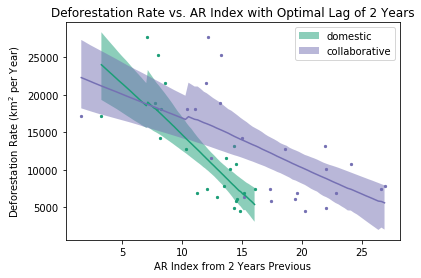

The average MSE of the valuation sets: 43825969.29049292
This occured when using a polynomial of order: 1


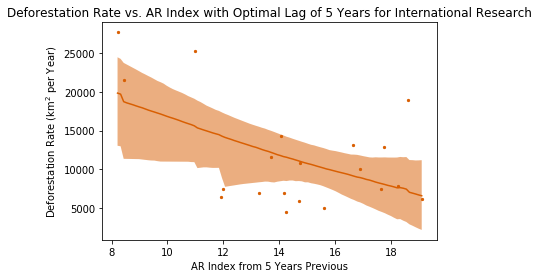

In [111]:
response = 'Deforestation_Rate'
poly_order_max = 5


variable_of_interest = 'AR_Index_2_Year_Prev'

[y_bootstrap_summary_domestic, x_array_domestic, MSE_min_domestic, optimal_poly_order_domestic] = bootstrap_polynomial_analysis(domestic_df_list[2], variable_of_interest, response, poly_order_max, len(domestic_df_list[2]))

plt.scatter(domestic_df_list[2][variable_of_interest], domestic_df_list[2][response], s=5, color=c_d)
plt.plot(x_array_domestic, y_bootstrap_summary_domestic['median'], c_d)
plt.fill_between(x_array_domestic, y_bootstrap_summary_domestic['95_CI_low'], y_bootstrap_summary_domestic['95_CI_high'], facecolor = c_d, alpha = 0.5, label='domestic')

[y_bootstrap_summary_collaborative, x_array_collaborative, MSE_min_collaborative, optimal_poly_order_collaborative] = bootstrap_polynomial_analysis(collaborative_df_list[2], variable_of_interest, response, poly_order_max, len(collaborative_df_list[2]))
plt.scatter(collaborative_df_list[2][variable_of_interest], collaborative_df_list[2][response], s=5, color=c_c)
plt.plot(x_array_collaborative, y_bootstrap_summary_collaborative['median'], c_c)
plt.fill_between(x_array_collaborative, y_bootstrap_summary_collaborative['95_CI_low'], y_bootstrap_summary_collaborative['95_CI_high'], facecolor = c_c, alpha = 0.5, label='collaborative')

plt.xlabel('AR Index from 2 Years Previous')
plt.ylabel(f'Deforestation Rate (km$^2$ per Year)')
plt.title(f'Deforestation Rate vs. AR Index with Optimal Lag of 2 Years')
plt.legend()
plt.show()



variable_of_interest = 'AR_Index_5_Year_Prev'

[y_bootstrap_summary_international, x_array_international, MSE_min_international, optimal_poly_order_international] = bootstrap_polynomial_analysis(international_df_list[5], variable_of_interest, response, poly_order_max, len(international_df_list[5]))
plt.scatter(international_df_list[5][variable_of_interest],international_df_list[5][response], s=5, color=c_i)
plt.plot(x_array_international, y_bootstrap_summary_international['median'], c_i)
plt.fill_between(x_array_international, y_bootstrap_summary_international['95_CI_low'], y_bootstrap_summary_international['95_CI_high'], facecolor = c_i, alpha = 0.5, label='international')
plt.xlabel('AR Index from 5 Years Previous')
plt.ylabel(f'Deforestation Rate (km$^2$ per Year)')
plt.title(f'Deforestation Rate vs. AR Index with Optimal Lag of 5 Years for International Research')
plt.show()

The average MSE of the valuation sets: 34410431.42016308
This occured when using a polynomial of order: 1
The average MSE of the valuation sets: 38405172.11956274
This occured when using a polynomial of order: 1
The average MSE of the valuation sets: 43825969.29049292
This occured when using a polynomial of order: 1


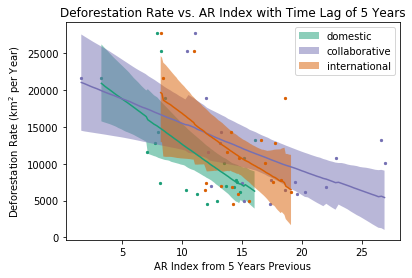

In [112]:
variable_of_interest = 'AR_Index_5_Year_Prev'


[y_bootstrap_summary_domestic, x_array_domestic, MSE_min_domestic, optimal_poly_order_domestic] = bootstrap_polynomial_analysis(domestic_df_list[5], variable_of_interest, response, poly_order_max, len(domestic_df_list[5]))

plt.scatter(domestic_df_list[5][variable_of_interest], domestic_df_list[5][response], s=5, color=c_d)
plt.plot(x_array_domestic, y_bootstrap_summary_domestic['median'], c_d)
plt.fill_between(x_array_domestic, y_bootstrap_summary_domestic['95_CI_low'], y_bootstrap_summary_domestic['95_CI_high'], facecolor = c_d, alpha = 0.5, label='domestic')

[y_bootstrap_summary_collaborative, x_array_collaborative, MSE_min_collaborative, optimal_poly_order_collaborative] = bootstrap_polynomial_analysis(collaborative_df_list[5], variable_of_interest, response, poly_order_max, len(collaborative_df_list[5]))
plt.scatter(collaborative_df_list[5][variable_of_interest], collaborative_df_list[5][response], s=5, color=c_c)
plt.plot(x_array_collaborative, y_bootstrap_summary_collaborative['median'], c_c)
plt.fill_between(x_array_collaborative, y_bootstrap_summary_collaborative['95_CI_low'], y_bootstrap_summary_collaborative['95_CI_high'], facecolor = c_c, alpha = 0.5, label='collaborative')

[y_bootstrap_summary_international, x_array_international, MSE_min_international, optimal_poly_order_international] = bootstrap_polynomial_analysis(international_df_list[5], variable_of_interest, response, poly_order_max, len(international_df_list[5]))
plt.scatter(international_df_list[5][variable_of_interest],international_df_list[5][response], s=5, color=c_i)
plt.plot(x_array_international, y_bootstrap_summary_international['median'], c_i)
plt.fill_between(x_array_international, y_bootstrap_summary_international['95_CI_low'], y_bootstrap_summary_international['95_CI_high'], facecolor = c_i, alpha = 0.5, label='international')

plt.xlabel('AR Index from 5 Years Previous')
plt.ylabel(f'Deforestation Rate (km$^2$ per Year)')
plt.title(f'Deforestation Rate vs. AR Index with Time Lag of 5 Years')
plt.legend()
plt.show()